# Machine Learning Engineer Nanodegree

## Capstone Project

Joe Udacity  
December 31st, 2050

## I. Definition

_(approx. 1-2 pages)_

### Project Overview

In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_

### Problem Statement

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_

### Metrics

In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_

## II. Analysis

_(approx. 2-4 pages)_

### Data Exploration

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

In [2]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 10.1 MB/s eta 0:00:00


In [21]:
#General dependencies
import sagemaker
import pandas as pd
import boto3
import os

#Data preprocessing
from io import StringIO
from category_encoders import BinaryEncoder

#Model training and hyperparameter tuning
from sagemaker.estimator import Estimator
from sagemaker.pytorch import PyTorch 
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, \
    HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
# from sagemaker.pytorch import PyTorch


In [4]:
#Prepare commonly used objects
session = sagemaker.session.Session()
bucket = session.default_bucket()
s3_client = boto3.client('s3')
role = sagemaker.get_execution_role()

In [5]:
response = s3_client.get_object(Bucket=bucket, Key='data/data.csv')
body=response['Body']

In [6]:
#Import dataset from s3
data = body.read().decode('utf-8')
df = pd.read_csv(StringIO(data))

/tmp/ipykernel_13001/285887691.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(data))


In [7]:
df.head()

,deceased,subject_id,gender,race,arrival_transport,existing_doses,medicine_dispensations,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,0,14188788,1,OTHER,AMBULANCE,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,19659841,1,OTHER,AMBULANCE,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,11074777,1,WHITE,WALK IN,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,11075647,0,WHITE,WALK IN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,11858930,1,WHITE,HELICOPTER,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205504 entries, 0 to 205503
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   deceased                205504 non-null  int64  
 1   subject_id              205504 non-null  int64  
 2   gender                  205504 non-null  int64  
 3   race                    205504 non-null  object 
 4   arrival_transport       205504 non-null  object 
 5   existing_doses          205504 non-null  int64  
 6   medicine_dispensations  205504 non-null  int64  
 7   temperature             191025 non-null  float64
 8   heartrate               194174 non-null  float64
 9   resprate                192573 non-null  float64
 10  o2sat                   192534 non-null  float64
 11  sbp                     193632 non-null  float64
 12  dbp                     193241 non-null  float64
 13  pain                    197462 non-null  object 
 14  acuity              

In [9]:
for column in df.columns:
    print(column)
    missing_values = df[column].isna().sum()
    print(f'Missing values: {missing_values}')
    print(f'Percentage missing values: {missing_values / len(df[column]) : .2%}', '\n')

deceased
Missing values: 0
Percentage missing values:  0.00% 

subject_id
Missing values: 0
Percentage missing values:  0.00% 

gender
Missing values: 0
Percentage missing values:  0.00% 

race
Missing values: 0
Percentage missing values:  0.00% 

arrival_transport
Missing values: 0
Percentage missing values:  0.00% 

existing_doses
Missing values: 0
Percentage missing values:  0.00% 

medicine_dispensations
Missing values: 0
Percentage missing values:  0.00% 

temperature
Missing values: 14479
Percentage missing values:  7.05% 

heartrate
Missing values: 11330
Percentage missing values:  5.51% 

resprate
Missing values: 12931
Percentage missing values:  6.29% 

o2sat
Missing values: 12970
Percentage missing values:  6.31% 

sbp
Missing values: 11872
Percentage missing values:  5.78% 

dbp
Missing values: 12263
Percentage missing values:  5.97% 

pain
Missing values: 8042
Percentage missing values:  3.91% 

acuity
Missing values: 5076
Percentage missing values:  2.47% 



In [10]:
for column in df.columns:
    print(df[column].value_counts())

0    186330
1     19174
Name: deceased, dtype: int64
14188788    1
12272035    1
15947312    1
15327112    1
11648349    1
           ..
16094974    1
16106036    1
16355756    1
16476300    1
13716295    1
Name: subject_id, Length: 205504, dtype: int64
0    109545
1     95959
Name: gender, dtype: int64
WHITE                                        118962
BLACK/AFRICAN AMERICAN                        25677
OTHER                                         11875
UNKNOWN                                        6409
ASIAN                                          4955
HISPANIC/LATINO - PUERTO RICAN                 4623
WHITE - OTHER EUROPEAN                         4512
ASIAN - CHINESE                                4159
HISPANIC/LATINO - DOMINICAN                    3225
BLACK/CAPE VERDEAN                             2789
BLACK/AFRICAN                                  2405
WHITE - RUSSIAN                                2213
BLACK/CARIBBEAN ISLAND                         1667
HISPANIC OR LATINO 

In [11]:
print(df['pain'].unique())

[nan '&' ')' '+' '-' '.' '0' 0 1 2 3 4 5 6 '6' '7' '8' '9' '?' 'C' 'T' 'U'
 'c' 'i' 'o' 's' 't' 'u' ' 0' ' 4' ' 6' ' c' '++' '-0' '.0' '.3' '.5' '/?'
 '0 ' '0-' '0.' '0/' '00' '01' '03' '06' '07' '08' '09' '10' '11' '12'
 '13' '14' '15' '16' '18' '19' '2,' '2.' '20' '23' '3 ' '3t' '5 ' '51'
 '54' '56' '6 ' '61' '68' '6`' '7/' '70' '73' '75' '8 ' '8,' '8.' '8/'
 '88' '9 ' '9+' '90' '95' '97' '98' '<1' '?/' '??' 'CP' 'RA' 'UA' 'Ua'
 'na' 'no' 'o3' 'ok' 'ph' 'ra' 'uA' 'ua' 'un' 'ut' ' 10' '0  ' '0, ' '0-1'
 '0-2' '0-5' '0-7' '0-8' '0-9' '0..' '0.5' '069' '1 0' '1-2' '1-3' '1-7'
 '1.2' '1.5' '1/2' '10 ' '10+' '10.' '10/' '100' '134' '180' '1`0' '2-3'
 '2-4' '2-6' '2-7' '2-8' '2-9' '2. ' '2.5' '3  ' '3-4' '3-5' '3-6' '3-7'
 '3.5' '4-5' '4-8' '4. ' '4.5' '4/9' '5-6' '5-8' '5-9' '5.5' '5.8' '5/7'
 '5/8' '5/9' '6-7' '6-8' '6-9' '6.5' '7-6' '7-8' '7-9' '7.5' '7/8' '8  '
 '8-9' '8.5' '8.6' '8.7' '8/6' '8/9' '9  ' '9-8' '9.4' '9.5' '9.7' '9.9'
 '9/6' '>10' 'AMS' 'Bad' 'ETT' 'INT' 'NAD' 'Pt ' 'Ref

### Exploratory Visualization

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

<AxesSubplot:>

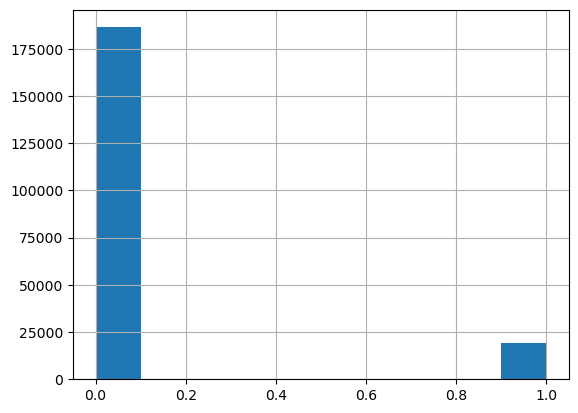

In [12]:
df['deceased'].hist()

### Algorithms and Techniques

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

### Benchmark

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

## III. Methodology

_(approx. 3-5 pages)_

### Data Preprocessing

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

Drop unused columns

In [13]:
df = df.drop(axis=1, columns=['subject_id', 'pain'])

Drop null values

In [14]:
df = df.dropna()

Encode categorical variables

In [15]:
dummies = pd.get_dummies(df['arrival_transport'], prefix='arrival_transport', drop_first=True)
df = df.join(dummies)
df = df.drop('arrival_transport', axis=1)


df = BinaryEncoder(cols=['race'], drop_invariant=True).fit_transform(df)
df.head()
# df = df.drop('race', axis=1)

,deceased,gender,race_0,race_1,race_2,race_3,race_4,race_5,existing_doses,medicine_dispensations,...,heartrate,resprate,o2sat,sbp,dbp,acuity,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN
6267,1,0,0,0,0,0,0,1,16,7,...,103.0,18.0,90.0,121.0,74.0,2.0,0,0,0,1
6268,0,0,0,0,0,0,0,1,7,0,...,91.0,19.0,90.0,141.0,74.0,2.0,0,0,0,0
6269,0,1,0,0,0,0,1,0,15,21,...,138.0,24.0,90.0,148.0,80.0,1.0,0,0,0,0
6270,0,0,0,0,0,0,1,1,17,4,...,70.0,34.0,90.0,185.0,74.0,1.0,0,0,0,1
6271,0,1,0,0,0,1,0,0,0,2,...,125.0,10.0,90.0,133.0,85.0,1.0,0,0,0,0


Scale these two columns

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[ ['existing_doses', 'medicine_dispensations'] ] = scaler.fit_transform(
    df[ ['existing_doses', 'medicine_dispensations'] ])

Drop erroneous readings

In [17]:
# sbp - drop values higher than 300 (even then, these are extreme)
# dbp - drop values higher than 300 (even then, these are extreme)
df = df[ (df['sbp'] <= 300) & (df['dbp'] <= 300) ]

Save processed file to s3

In [18]:
int_columns=['race_0','race_1','race_2','race_3','race_4','race_5','arrival_transport_HELICOPTER',
            'arrival_transport_OTHER','arrival_transport_UNKNOWN','arrival_transport_WALK IN']
float_columns=['existing_doses','medicine_dispensations','temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
df['deceased']=df['deceased'].astype('bool')
df[int_columns]=df[int_columns].astype('int')
df[float_columns]=df[float_columns].astype('float')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186540 entries, 6267 to 205503
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   deceased                      186540 non-null  bool   
 1   gender                        186540 non-null  int64  
 2   race_0                        186540 non-null  int64  
 3   race_1                        186540 non-null  int64  
 4   race_2                        186540 non-null  int64  
 5   race_3                        186540 non-null  int64  
 6   race_4                        186540 non-null  int64  
 7   race_5                        186540 non-null  int64  
 8   existing_doses                186540 non-null  float64
 9   medicine_dispensations        186540 non-null  float64
 10  temperature                   186540 non-null  float64
 11  heartrate                     186540 non-null  float64
 12  resprate                      186540 non-

In [55]:
file_name='cleaned_data.csv'
s3_prefix='data'
object_name=os.path.join(s3_prefix, file_name)
#Create csv from cleaned dataframe
df.to_csv(file_name,index=False)
#Save csv on s3 bucket
try:
    response = s3_client.upload_file(file_name, bucket, object_name)
except ClientError as e:
    print(e)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186540 entries, 6267 to 205503
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   deceased                      186540 non-null  int64  
 1   gender                        186540 non-null  int64  
 2   race_0                        186540 non-null  int64  
 3   race_1                        186540 non-null  int64  
 4   race_2                        186540 non-null  int64  
 5   race_3                        186540 non-null  int64  
 6   race_4                        186540 non-null  int64  
 7   race_5                        186540 non-null  int64  
 8   existing_doses                186540 non-null  float64
 9   medicine_dispensations        186540 non-null  float64
 10  temperature                   186540 non-null  float64
 11  heartrate                     186540 non-null  float64
 12  resprate                      186540 non-

### Implementation

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

In [56]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-4, 1, scaling_type="Logarithmic"),
    "num_iterations": IntegerParameter(2, 30),
    "early_stopping_rounds": IntegerParameter(2, 30),
    "num_leaves": IntegerParameter(10, 50),
    "max_depth": IntegerParameter(5, 30),
}
objective_metric_name = "Test Accuracy"
objective_type="Maximize"
metric_definitions=[{"Name": "Test Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [57]:
# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.

train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

#Looking at example project
# print(train_source_uri)
# response = s3_client.get_object(Bucket='jumpstart-cache-prod-us-east-1', Key='source-directory-tarballs/lightgbm/transfer_learning/classification/v2.1.1/sourcedir.tar.gz')
# body=response['Body']
# with open('sourcedir.tar.gz','wb') as f:
#     f.write(body.read())

In [62]:
# estimator = PyTorch(
#     entry_point="hpo.py",
#     role=role,
#     instance_count=3,
#     instance_type="ml.m5.xlarge",
#     framework_version="1.12.0",
#     py_version='py38',
#     source_dir='code/'
# )
estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir="code/",
    entry_point="hpo.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    output_path='s3://'+bucket+'/hpo/'
)
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [25]:
base_path = os.path.join('s3://', bucket)
# os.environ['SM_CHANNEL_TRAINING']=os.path.join(base_path,'data')
# os.environ['SM_MODEL_DIR']=os.path.join(base_path,'model')
# os.environ['SM_OUTPUT_DATA_DIR']=os.path.join(base_path,'output')
#Setting varibles here doesnt affect the training (hyperparmeter tuning) environment. Research how to change default values

In [63]:
tuner.fit({"training": base_path}, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................!


Describe the tuning results

In [64]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230402-1939')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""1024""","""15""",0.001354,pytorch-training-230402-1939-002-4b5b409a,Completed,0.914841,2023-04-02 19:40:23+00:00,2023-04-02 19:42:25+00:00,122.0
1,"""1024""","""10""",0.033328,pytorch-training-230402-1939-001-e5e8c553,Completed,0.914841,2023-04-02 19:40:18+00:00,2023-04-02 19:42:26+00:00,128.0


In [65]:
#Get the hyperparameters of the best trained model
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-04-03 05:19:42 Starting - Preparing the instances for training
2023-04-03 05:19:42 Downloading - Downloading input data
2023-04-03 05:19:42 Training - Training image download completed. Training in progress.
2023-04-03 05:19:42 Uploading - Uploading generated training model
2023-04-03 05:19:42 Completed - Resource retained for reuse


{'_tuning_objective_metric': 'Test Accuracy',
 'early_stopping_rounds': '25',
 'learning_rate': '0.4921729293048727',
 'max_depth': '15',
 'num_iterations': '29',
 'num_leaves': '10',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"pytorch-training-2023-04-03-05-16-20-121"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-927441871693/pytorch-training-2023-04-03-05-16-20-121/source/sourcedir.tar.gz"'}

### Refinement

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_

In [22]:
best_hyperparameters = {
    'early_stopping_rounds': '25',
    'learning_rate': '0.4921729293048727',
    'max_depth': '15',
    'num_iterations': '29',
    'num_leaves': '10',
}

In [68]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

In [23]:
deploy_estimator = PyTorch(
    entry_point="train_and_deploy.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="1.12.0",
    py_version='py38',
    source_dir='code/',
    hyperparameters=best_hyperparameters,
)
# deploy_estimator = Estimator(
#     role=role,
#     image_uri=deploy_image_uri,
#     source_dir="code/",
#     entry_point="train_and_deploy.py",
#     instance_count=1,
#     instance_type=inference_instance_type,
#     hyperparameters=best_hyperparameters,
#     output_path='s3://'+bucket+'/training/'
# )

# Estimator(
#     role=role,
#     image_uri=train_image_uri,
#     source_dir="code/",
#     entry_point="hpo.py",
#     instance_count=1,
#     instance_type=training_instance_type,
#     max_run=360000,
#     output_path='s3://'+bucket+'/hpo/'
# )

In [26]:
deploy_estimator.fit({"training": base_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-03-14-34-56-234


2023-04-03 14:35:33 Starting - Starting the training job...
2023-04-03 14:35:51 Starting - Preparing the instances for training......
2023-04-03 14:37:03 Downloading - Downloading input data
2023-04-03 14:37:03 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-03 14:37:46,382 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-03 14:37:46,384 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-03 14:37:46,391 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-03 14:37:46,393 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-03 14:37:47,987 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
predictor = deploy_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: pytorch-training-2023-04-03-14-47-56-259
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-04-03-14-47-56-259
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-04-03-14-47-56-259


------!

In [32]:
#Randomly select a sample (row) from the entire dataset, and make a prediction
# import torch
test_sample = df.sample()
# tensors = torch.tensor(test_sample.to_numpy())
response = predictor.predict(test_sample.drop(columns='deceased'))

# tensors = torch.tensor(test_sample.to_numpy())
    # prediction = retreived_model.predict(tensors)
print(response)

[0]


In [37]:
print(f'''The correct label was: {test_sample['deceased']}. The predicted label was: {bool(response[0])}''')

The correct label was: 137500    False
Name: deceased, dtype: bool. The predicted label was: False


## IV. Results

_(approx. 2-3 pages)_

### Model Evaluation and Validation

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion

_(approx. 1-2 pages)_

### Free-Form Visualization

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection

In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement

In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?